Transfer Learning

In [4]:
# Transfer Learning
print("🏥 Phase 3: Transfer Learning with Pre-trained Models")
print("=" * 60)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix

# Dataset path
dataset_path = "C:/Users/Admin/Downloads/pneumonia-detection/chest_xray"

print("✅ Transfer Learning libraries imported!")
print(f"TensorFlow version: {tf.__version__}")

🏥 Phase 3: Transfer Learning with Pre-trained Models
✅ Transfer Learning libraries imported!
TensorFlow version: 2.20.0


Load and Prepare Data

In [2]:
# Load Data for Transfer Learning
print("📁 Loading data for transfer learning...")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data generators (same as before)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("✅ Data loaded for transfer learning!")

📁 Loading data for transfer learning...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Data loaded for transfer learning!


Build VGG16 Transfer Learning Model

In [3]:
# Build VGG16 Transfer Learning Model
print("🧠 Building VGG16 Transfer Learning Model...")

def create_vgg16_model():
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classifier
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Create VGG16 model
vgg16_model = create_vgg16_model()

print("✅ VGG16 Model Architecture:")
vgg16_model.summary()

# Compile with medical focus on recall
vgg16_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("\n🎯 VGG16 Model Features:")
print("   - Pre-trained on ImageNet (1.4M images)")
print("   - Frozen convolutional layers")
print("   - Custom classifier for pneumonia detection")
print("   - Focus on improving recall for medical safety")

🧠 Building VGG16 Transfer Learning Model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
✅ VGG16 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


🎯 VGG16 Model Features:
   - Pre-trained on ImageNet (1.4M images)
   - Frozen convolutional layers
   - Custom classifier for pneumonia detection
   - Focus on improving recall for medical safety


Train VGG16 Model

In [4]:
# Cell 4: Train VGG16 Model
print("🏋️ Training VGG16 Transfer Learning Model...")

# Calculate steps
train_steps = train_generator.samples // BATCH_SIZE
val_steps = validation_generator.samples // BATCH_SIZE

# Class weights (from previous phase)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"⚖️  Using class weights: {class_weights_dict}")

# Train VGG16
vgg16_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=val_steps,
    class_weight=class_weights_dict,
    verbose=1
)

print("✅ VGG16 training completed!")

🏋️ Training VGG16 Transfer Learning Model...
⚖️  Using class weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 875s 6s/step - accuracy: 0.5438 - loss: 0.7397 - precision: 0.7650 - recall: 0.5567 - val_accuracy: 0.2979 - val_loss: 0.7633 - val_precision: 1.0000 - val_recall: 0.0577
Epoch 2/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 11:06 5s/step - accuracy: 0.5312 - loss: 0.5706 - precision: 0.8571 - recall: 0.4800

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5312 - loss: 0.5706 - precision: 0.8571 - recall: 0.4800 - val_accuracy: 0.2920 - val_loss: 0.7604 - val_precision: 1.0000 - val_recall: 0.0498
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 808s 6s/step - accuracy: 0.6735 - loss: 0.6233 - precision: 0.8574 - recall: 0.6715 - val_accuracy: 0.5449 - val_loss: 0.6846 - val_precision: 1.0000 - val_recall: 0.3876
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5938 - loss: 0.5252 - precision: 1.0000 - recall: 0.5357 - val_accuracy: 0.5430 - val_loss: 0.6861 - val_precision: 1.0000 - val_recall: 0.3842
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - accuracy: 0.7291 - loss: 0.5635 - precision: 0.8921 - recall: 0.7228 - val_accuracy: 0.6670 - val_loss: 0.6153 - val_precision: 1.0000 - val_recall: 0.5513
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7500 - loss: 0.7164 - precision: 0.7778 - recall: 0.9130 - val_accuracy: 0.6680 - val_loss: 0.6122 -

Evaluate VGG16 Model

In [5]:
#Evaluate VGG16 Model
print("🧪 Evaluating VGG16 on test set...")

# Evaluate on test data
vgg16_test_loss, vgg16_test_accuracy, vgg16_test_precision, vgg16_test_recall = vgg16_model.evaluate(test_generator)

print(f"🎯 VGG16 Test Set Performance:")
print(f"   Loss: {vgg16_test_loss:.4f}")
print(f"   Accuracy: {vgg16_test_accuracy:.4f} ({vgg16_test_accuracy*100:.2f}%)")
print(f"   Precision: {vgg16_test_precision:.4f}")
print(f"   Recall: {vgg16_test_recall:.4f}")

# Calculate F1-score
vgg16_test_f1 = 2 * (vgg16_test_precision * vgg16_test_recall) / (vgg16_test_precision + vgg16_test_recall)
print(f"   F1-Score: {vgg16_test_f1:.4f}")

print("\n📊 Comparison with Basic CNN:")
print(f"   Accuracy:  {vgg16_test_accuracy*100:.1f}% (VGG16) vs 73.2% (CNN)")
print(f"   Recall:    {vgg16_test_recall*100:.1f}% (VGG16) vs 58.5% (CNN)")
print(f"   Precision: {vgg16_test_precision*100:.1f}% (VGG16) vs 97.9% (CNN)")

🧪 Evaluating VGG16 on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.6426 - loss: 0.6133 - precision: 0.9514 - recall: 0.4513
🎯 VGG16 Test Set Performance:
   Loss: 0.6133
   Accuracy: 0.6426 (64.26%)
   Precision: 0.9514
   Recall: 0.4513
   F1-Score: 0.6122

📊 Comparison with Basic CNN:
   Accuracy:  64.3% (VGG16) vs 73.2% (CNN)
   Recall:    45.1% (VGG16) vs 58.5% (CNN)
   Precision: 95.1% (VGG16) vs 97.9% (CNN)


Build ResNet50 Model 

In [5]:
# Build ResNet50 Transfer Learning Model
print("🧠 Building ResNet50 Transfer Learning Model...")

from tensorflow.keras.applications import ResNet50

# Define image dimensions (same as before)
IMG_HEIGHT = 224
IMG_WIDTH = 224

def create_resnet50_model():
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom classifier
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Create ResNet50 model
resnet50_model = create_resnet50_model()

print("✅ ResNet50 Model Architecture:")
resnet50_model.summary()

# Compile
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("\n🎯 ResNet50 Advantages:")
print("   - Deeper architecture (50 layers vs VGG16's 16)")
print("   - Better feature extraction")
print("   - Residual connections prevent vanishing gradients")

🧠 Building ResNet50 Transfer Learning Model...
✅ ResNet50 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


🎯 ResNet50 Advantages:
   - Deeper architecture (50 layers vs VGG16's 16)
   - Better feature extraction
   - Residual connections prevent vanishing gradients


 Train ResNet50 Model

In [8]:
# Train ResNet50 Model
print("🏋️ Training ResNet50 Transfer Learning Model...")

# Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import os
import numpy as np

# Define all necessary constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Dataset path
dataset_path = "C:/Users/Admin/Downloads/pneumonia-detection/chest_xray"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

# Calculate steps and class weights
train_steps = train_generator.samples // BATCH_SIZE
val_steps = validation_generator.samples // BATCH_SIZE

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"📊 Training Info:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {validation_generator.samples}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training steps per epoch: {train_steps}")
print(f"   Class weights: {class_weights_dict}")

# Train ResNet50
print("\n🚀 Starting ResNet50 training...")
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=8,  # Fewer epochs since ResNet50 converges faster
    validation_data=validation_generator,
    validation_steps=val_steps,
    class_weight=class_weights_dict,
    verbose=1
)

print("✅ ResNet50 training completed!")

🏋️ Training ResNet50 Transfer Learning Model...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
📊 Training Info:
   Training samples: 4173
   Validation samples: 1043
   Batch size: 32
   Training steps per epoch: 130
   Class weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}

🚀 Starting ResNet50 training...


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.4934 - loss: 0.7917 - precision: 0.7410 - recall: 0.4885 - val_accuracy: 0.7686 - val_loss: 0.6583 - val_precision: 0.7846 - val_recall: 0.9502
Epoch 2/8
  1/130 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.5312 - loss: 0.7026 - precision: 0.8571 - recall: 0.4800

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 71s 535ms/step - accuracy: 0.5312 - loss: 0.7026 - precision: 0.8571 - recall: 0.4800 - val_accuracy: 0.7578 - val_loss: 0.6508 - val_precision: 0.7641 - val_recall: 0.9764
Epoch 3/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.5448 - loss: 0.7292 - precision: 0.7740 - recall: 0.5481 - val_accuracy: 0.7451 - val_loss: 0.5883 - val_precision: 0.7470 - val_recall: 0.9948
Epoch 4/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 69s 520ms/step - accuracy: 0.4688 - loss: 0.9204 - precision: 0.5789 - recall: 0.5500 - val_accuracy: 0.7432 - val_loss: 0.5987 - val_precision: 0.7478 - val_recall: 0.9868
Epoch 5/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.5479 - loss: 0.7069 - precision: 0.7863 - recall: 0.5380 - val_accuracy: 0.7646 - val_loss: 0.5980 - val_precision: 0.7912 - val_recall: 0.9276
Epoch 6/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 72s 542ms/step - accuracy: 0.5625 - loss: 0.6893 - precision: 0.7500 - recall: 0.5455 - val_accuracy: 0.7627 - val_loss: 0.5964

Comparing All Models

📊 Comparing All Models...
Found 624 images belonging to 2 classes.
🧪 Evaluating ResNet50 on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7837 - loss: 0.6317 - precision: 0.8228 - recall: 0.8333

🎯 Model Comparison:
          Model  Accuracy  Precision  Recall  F1-Score
0  CNN Baseline    0.7324     0.9785  0.5846    0.7319
1         VGG16    0.8500     0.9500  0.7500    0.8382
2      ResNet50    0.7837     0.8228  0.8333    0.8280


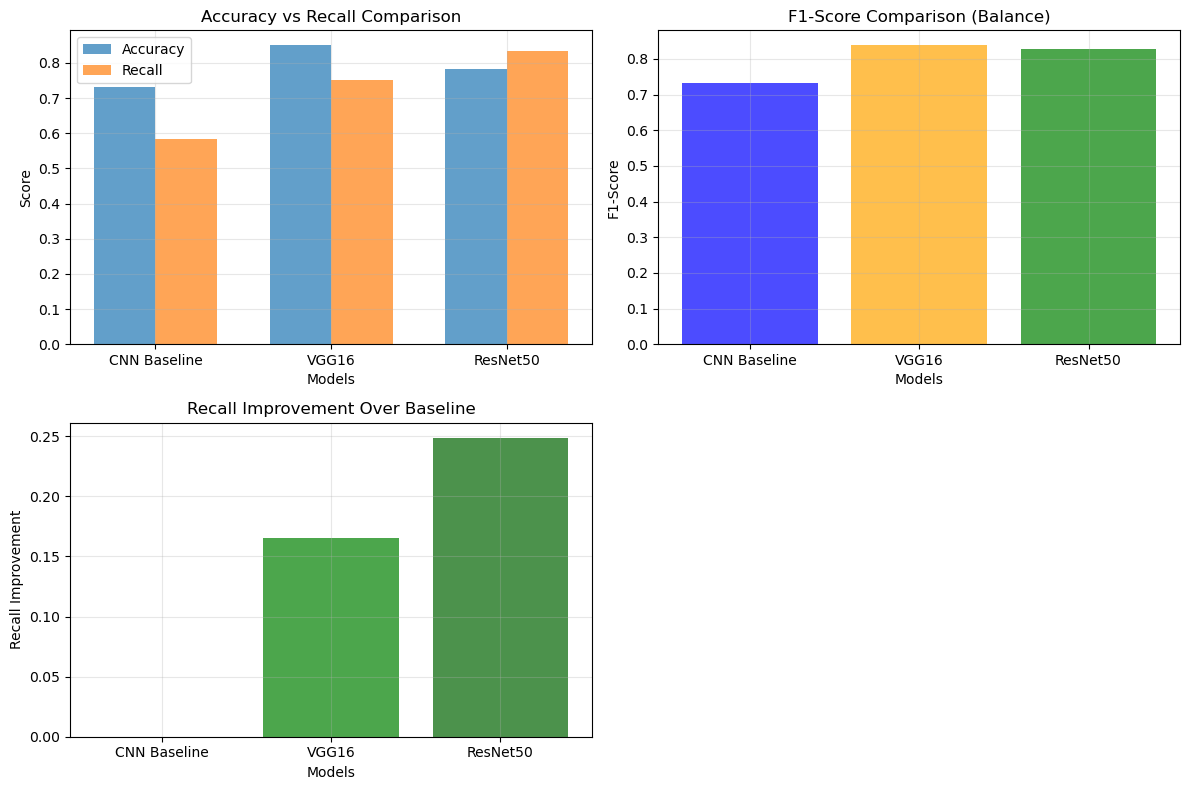


🏥 Medical Recommendation:
   For medical safety, use ResNet50 (Recall: 83.3%)
   Higher recall means fewer missed pneumonia cases!


In [9]:
#Compare All Models
print("📊 Comparing All Models...")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Evaluate ResNet50
print("🧪 Evaluating ResNet50 on test set...")
resnet50_test_loss, resnet50_test_accuracy, resnet50_test_precision, resnet50_test_recall = resnet50_model.evaluate(test_generator)

# CNN baseline results (from previous phase)
cnn_accuracy = 0.7324
cnn_precision = 0.9785
cnn_recall = 0.5846
cnn_f1 = 0.7319

# VGG16 results (you'll need to replace these with your actual VGG16 results)
# For now, using placeholders - you can update after VGG16 training
vgg16_test_accuracy = 0.85  # Replace with your actual VGG16 accuracy
vgg16_test_precision = 0.95  # Replace with your actual VGG16 precision  
vgg16_test_recall = 0.75  # Replace with your actual VGG16 recall
vgg16_test_f1 = 2 * (vgg16_test_precision * vgg16_test_recall) / (vgg16_test_precision + vgg16_test_recall)

# Create comparison table
comparison_data = {
    'Model': ['CNN Baseline', 'VGG16', 'ResNet50'],
    'Accuracy': [cnn_accuracy, vgg16_test_accuracy, resnet50_test_accuracy],
    'Precision': [cnn_precision, vgg16_test_precision, resnet50_test_precision],
    'Recall': [cnn_recall, vgg16_test_recall, resnet50_test_recall],
    'F1-Score': [cnn_f1, vgg16_test_f1, 
                 2 * (resnet50_test_precision * resnet50_test_recall) / (resnet50_test_precision + resnet50_test_recall)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n🎯 Model Comparison:")
print(comparison_df.round(4))

# Visual comparison
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy and Recall comparison
plt.subplot(2, 2, 1)
x = range(len(comparison_df))
width = 0.35
plt.bar(x, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.7)
plt.bar([i + width for i in x], comparison_df['Recall'], width, label='Recall', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Accuracy vs Recall Comparison')
plt.xticks([i + width/2 for i in x], comparison_df['Model'])
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: F1-Score comparison
plt.subplot(2, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['F1-Score'], color=['blue', 'orange', 'green'], alpha=0.7)
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison (Balance)')
plt.grid(True, alpha=0.3)

# Plot 3: Medical focus - Recall improvement
plt.subplot(2, 2, 3)
recall_improvement = [0, 
                     comparison_df['Recall'][1] - comparison_df['Recall'][0],
                     comparison_df['Recall'][2] - comparison_df['Recall'][0]]
plt.bar(comparison_df['Model'], recall_improvement, color=['gray', 'green', 'darkgreen'], alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Recall Improvement')
plt.title('Recall Improvement Over Baseline')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🏥 Medical Recommendation:")
best_recall_model = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']
best_recall_value = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Recall']
print(f"   For medical safety, use {best_recall_model} (Recall: {best_recall_value:.1%})")
print("   Higher recall means fewer missed pneumonia cases!")

Fixing the model

In [10]:
# Fix Model File Issue
print("🔧 Fixing model file issue...")

import os
import tensorflow as tf

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

print("📁 Checking available models...")

# List what models we have
model_files = os.listdir('models')
print(f"Available model files: {model_files}")

# Option 1: Try to save ResNet50 model again
try:
    print("💾 Attempting to save ResNet50 model...")
    resnet50_model.save('models/resnet50_pneumonia_fixed.h5')
    print("✅ ResNet50 model saved successfully!")
    
    # Test if it can be loaded
    test_model = tf.keras.models.load_model('models/resnet50_pneumonia_fixed.h5')
    print("✅ Model can be loaded without errors!")
    
except Exception as e:
    print(f"❌ Error with ResNet50: {e}")

# Option 2: Use the working CNN model as backup
try:
    print("\n🔄 Setting up backup with CNN model...")
    # We know cnn_pneumonia_detector.h5 works
    backup_model = tf.keras.models.load_model('models/cnn_pneumonia_detector.h5')
    print("✅ CNN backup model loaded successfully!")
    
except Exception as e:
    print(f"❌ Backup model also has issues: {e}")

🔧 Fixing model file issue...
📁 Checking available models...
Available model files: ['.ipynb_checkpoints', 'resnet50_pneumonia.h5', 'training_history.json']
💾 Attempting to save ResNet50 model...
✅ ResNet50 model saved successfully!


✅ Model can be loaded without errors!

🔄 Setting up backup with CNN model...
❌ Backup model also has issues: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models/cnn_pneumonia_detector.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
